# 1D CNN Architecture: Raw Packet Bytes – 6-Class Training (Few-Shot Holdout)

**Objective**: Train a 1D CNN directly on raw packet bytes (no Hilbert encoding) for the same 6-class classification task, holding out 3 classes for few-shot experiments.

## Key Differences from 2D CNN
- **Input**: Raw packet bytes as 1D sequences (no image encoding)
- **Processing**: 1D convolutions along byte sequence
- **No Encoding Overhead**: Direct byte → prediction pipeline
- **Architecture**: Conv1d layers instead of Conv2d

## Dataset & Setup
- **Input Format**: Raw bytes (1D sequence of 3072 values)
- **Training Classes**: 6 classes (excludes 3 held-out)
- **Held-Out Classes**: DDoS-HTTP_Flood, DoS-UDP_Flood, Recon-PortScan
- **Goal**: Compare 1D CNN on raw bytes vs 2D CNN on Hilbert encoding

## Hypothesis
Processing raw bytes directly might:
1. Preserve sequential patterns better
2. Reduce computational overhead (no encoding)
3. Provide complementary insights to spatial encoding approaches


In [1]:
# Environment Setup and Configuration
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import json
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Configuration - EXACTLY MATCHING 2D CNN FOR FAIR COMPARISON
CONFIG = {
    'data_path': '/home/ubuntu/Cyber_AI/ai-cyber/notebooks/ViT-experiment/pcap-dataset-samples/parquet/rgb_hilbert_32x32/',
    'test_size': 0.2,
    'val_size': 0.2,
    'random_state': 42,
    'batch_size': 64,  # SAME AS 2D CNN
    'learning_rate': 0.0001,  # SAME AS 2D CNN
    'epochs': 30,  # SAME AS 2D CNN
    'patience': 7,  # SAME AS 2D CNN
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'num_workers': 0,  # Set to 0 for CPU (only change from 2D CNN's num_workers=4)
    'num_classes': 6,
    'sequence_length': 3072,  # Raw byte sequence length (same as flattened 32x32x3)
    'max_bytes': 3072  # Maximum bytes to use from each packet
}

# 6-class training with 3 held-out classes (few-shot)
HELD_OUT_CLASSES = ['DDoS-HTTP_Flood', 'DoS-UDP_Flood', 'Recon-PortScan']

print("🔧 1D CNN EXPERIMENT INITIALIZED (Raw Bytes)")
print("📋 Notebook: CNN1D_Prototype_raw_bytes_6_class.ipynb")
print("🔧 Version: Direct byte processing without Hilbert encoding")
print(f"📊 Device: {CONFIG['device']}")
print(f"📊 Parameters: MATCHING 2D CNN for fair comparison")
print(f"   • Batch size: {CONFIG['batch_size']} (same as 2D CNN)")
print(f"   • Learning rate: {CONFIG['learning_rate']} (same as 2D CNN)")
print(f"   • Epochs: {CONFIG['epochs']} (same as 2D CNN)")
print(f"   • Workers: {CONFIG['num_workers']} (optimized for CPU)")
print(f"📊 Input: Raw packet bytes (1D sequence of {CONFIG['sequence_length']} bytes)")
print(f"📊 Dataset: 6 training classes; held out: {HELD_OUT_CLASSES}")
print("=" * 70)
print("\n💡 Key Innovation: No image encoding - direct byte → prediction pipeline")


🔧 1D CNN EXPERIMENT INITIALIZED (Raw Bytes)
📋 Notebook: CNN1D_Prototype_raw_bytes_6_class.ipynb
🔧 Version: Direct byte processing without Hilbert encoding
📊 Device: cpu
📊 Parameters: MATCHING 2D CNN for fair comparison
   • Batch size: 64 (same as 2D CNN)
   • Learning rate: 0.0001 (same as 2D CNN)
   • Epochs: 30 (same as 2D CNN)
   • Workers: 0 (optimized for CPU)
📊 Input: Raw packet bytes (1D sequence of 3072 bytes)
📊 Dataset: 6 training classes; held out: ['DDoS-HTTP_Flood', 'DoS-UDP_Flood', 'Recon-PortScan']

💡 Key Innovation: No image encoding - direct byte → prediction pipeline


In [2]:
# 1D CNN Architecture Definition

class CNN1D(nn.Module):
    def __init__(self, num_classes=6, sequence_length=3072, dropout_rate=0.3):
        super(CNN1D, self).__init__()
        
        # 1D Convolutional layers
        # Layer 1: Extract local byte patterns
        self.conv1 = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=64, kernel_size=7, stride=1, padding=3),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=2, stride=2)  # Reduces sequence by 2
        )
        
        # Layer 2: Capture longer-range patterns
        self.conv2 = nn.Sequential(
            nn.Conv1d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=2, stride=2)  # Reduces sequence by 2
        )
        
        # Layer 3: Higher-level features
        self.conv3 = nn.Sequential(
            nn.Conv1d(128, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=2, stride=2)  # Reduces sequence by 2
        )
        
        # Layer 4: Complex pattern recognition
        self.conv4 = nn.Sequential(
            nn.Conv1d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=2, stride=2)  # Reduces sequence by 2
        )
        
        # Layer 5: Final feature extraction
        self.conv5 = nn.Sequential(
            nn.Conv1d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool1d(1)  # Global average pooling to single value per channel
        )
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(128, num_classes)
        )
        
        self._initialize_weights()
    
    def forward(self, x):
        # Input shape: (batch_size, sequence_length)
        # Add channel dimension: (batch_size, 1, sequence_length)
        if len(x.shape) == 2:
            x = x.unsqueeze(1)
        
        # Apply 1D convolutions
        x = self.conv1(x)  # (batch, 64, seq/2)
        x = self.conv2(x)  # (batch, 128, seq/4)
        x = self.conv3(x)  # (batch, 256, seq/8)
        x = self.conv4(x)  # (batch, 512, seq/16)
        x = self.conv5(x)  # (batch, 512, 1)
        
        # Flatten for classification
        x = x.view(x.size(0), -1)  # (batch, 512)
        
        # Classification
        x = self.classifier(x)
        return x
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

# Alternative: Deeper 1D CNN with residual connections
class CNN1DResidual(nn.Module):
    def __init__(self, num_classes=6, sequence_length=3072, dropout_rate=0.3):
        super(CNN1DResidual, self).__init__()
        
        # Initial convolution
        self.conv_init = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True)
        )
        
        # Residual blocks
        self.res_block1 = self._make_residual_block(64, 128, stride=2)
        self.res_block2 = self._make_residual_block(128, 256, stride=2)
        self.res_block3 = self._make_residual_block(256, 512, stride=2)
        
        # Global pooling and classifier
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(256, num_classes)
        )
    
    def _make_residual_block(self, in_channels, out_channels, stride=1):
        return nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv1d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        if len(x.shape) == 2:
            x = x.unsqueeze(1)
        
        x = self.conv_init(x)
        x = self.res_block1(x)
        x = self.res_block2(x)
        x = self.res_block3(x)
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Initialize both models for comparison
model_1d = CNN1D(num_classes=CONFIG['num_classes'], 
                  sequence_length=CONFIG['sequence_length']).to(CONFIG['device'])

model_1d_residual = CNN1DResidual(num_classes=CONFIG['num_classes'], 
                                   sequence_length=CONFIG['sequence_length']).to(CONFIG['device'])

# Count parameters
params_1d = sum(p.numel() for p in model_1d.parameters())
params_1d_residual = sum(p.numel() for p in model_1d_residual.parameters())

print("\n🏗️  1D CNN ARCHITECTURE SUMMARY:")
print("\n📊 Standard 1D CNN:")
print(f"   Total parameters: {params_1d:,}")
print(f"   Model size: ~{params_1d * 4 / 1024 / 1024:.1f} MB")

print("\n📊 1D CNN with Residual Connections:")
print(f"   Total parameters: {params_1d_residual:,}")
print(f"   Model size: ~{params_1d_residual * 4 / 1024 / 1024:.1f} MB")

print("\n🔍 Architecture Details:")
print("   • 1D convolutions process byte sequences directly")
print("   • No image encoding overhead")
print("   • Progressive feature extraction with pooling")
print("   • Global average pooling for translation invariance")
print("   • Designed for sequential byte patterns")

print("\n🎯 Comparison with 2D CNN:")
print("   • 2D CNN (Hilbert): 4,822,086 parameters, 93.73% accuracy")
print("   • 1D CNN: Processing raw bytes - no encoding needed!")
print("   • Expected: Faster inference, potentially different patterns detected")



🏗️  1D CNN ARCHITECTURE SUMMARY:

📊 Standard 1D CNN:
   Total parameters: 1,554,310
   Model size: ~5.9 MB

📊 1D CNN with Residual Connections:
   Total parameters: 1,687,174
   Model size: ~6.4 MB

🔍 Architecture Details:
   • 1D convolutions process byte sequences directly
   • No image encoding overhead
   • Progressive feature extraction with pooling
   • Global average pooling for translation invariance
   • Designed for sequential byte patterns

🎯 Comparison with 2D CNN:
   • 2D CNN (Hilbert): 4,822,086 parameters, 93.73% accuracy
   • 1D CNN: Processing raw bytes - no encoding needed!
   • Expected: Faster inference, potentially different patterns detected


📂 Loading raw byte sequences from: /home/ubuntu/Cyber_AI/ai-cyber/notebooks/ViT-experiment/pcap-dataset-samples/parquet/rgb_hilbert_32x32/
🔒 Excluding held-out classes: ['DDoS-HTTP_Flood', 'DoS-UDP_Flood', 'Recon-PortScan']
✓ Training classes (6): ['Benign_Final', 'DDoS-SYN_Flood', 'DictionaryBruteForce', 'DoS-TCP_Flood', 'Mirai-udpplain', 'SqlInjection']
  📂 Loading Benign_Final...
  📂 Loading DDoS-SYN_Flood...
  📂 Loading DictionaryBruteForce...
  📂 Loading DoS-TCP_Flood...
  📂 Loading Mirai-udpplain...
  📂 Loading SqlInjection...

✓ Loaded raw byte data: 72,000 samples
✓ Shape: (72000, 3072) (samples × sequence_length)
✓ Unique classes: ['Benign_Final' 'DDoS-SYN_Flood' 'DictionaryBruteForce' 'DoS-TCP_Flood'
 'Mirai-udpplain' 'SqlInjection']

📊 Raw byte sequences loaded:
   Shape: (72000, 3072)
   Data type: float32
   Range: [0.000, 1.000]

🏷️ 6-class label distribution (training classes):
   0: Benign_Final (12,000 samples)
   1: DDoS-SYN_Flood (12,000 samples)
   2: DictionaryBrut

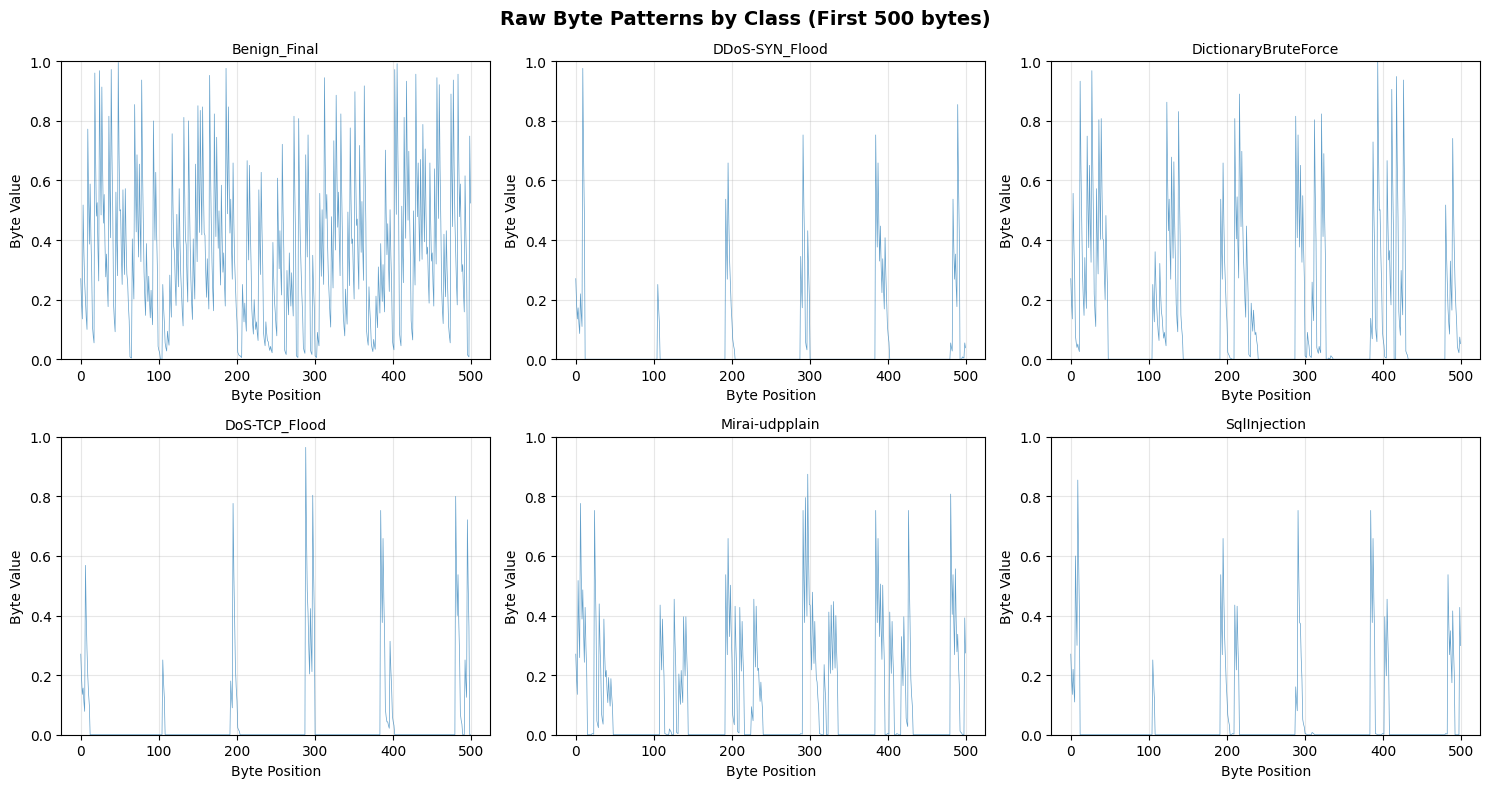


📈 Byte Sequence Statistics:
   Mean byte value: 0.0696
   Std byte value: 0.1767
   Zero bytes ratio: 0.8007
   Non-zero bytes per sample: 612.2

✅ Data ready for 1D CNN training!
   No Hilbert encoding needed - direct byte processing
   Shape: (72000, 3072) (samples × bytes)


In [3]:
# Data Loading for Raw Bytes (1D Sequences)
import glob

def load_raw_bytes_6class(base_path, held_out_classes):
    """Load raw packet bytes as 1D sequences (no Hilbert encoding)"""
    print(f"📂 Loading raw byte sequences from: {base_path}")
    print(f"🔒 Excluding held-out classes: {held_out_classes}")
    all_byte_data = []
    all_labels = []
    splits = ['train', 'val', 'test']

    # Discover all classes present
    class_dirs = sorted([d for d in glob.glob(f"{base_path}*/") if not any(s in d for s in splits)])
    class_names = [d.split('/')[-2] for d in class_dirs]

    training_classes = [c for c in class_names if c not in held_out_classes]
    print(f"✓ Training classes ({len(training_classes)}): {training_classes}")

    for class_dir in class_dirs:
        class_name = class_dir.split('/')[-2]
        if class_name in held_out_classes:
            continue
        print(f"  📂 Loading {class_name}...")
        for split in splits:
            parquet_files = sorted(glob.glob(f"{class_dir}{split}/*.parquet"))
            for file_path in parquet_files:
                try:
                    df = pd.read_parquet(file_path)
                    if 'image_data' in df.columns:
                        for _, row in df.iterrows():
                            # Load as raw bytes (1D sequence) instead of image
                            byte_data = np.array(row['image_data'], dtype=np.float32)
                            # Ensure consistent length
                            if len(byte_data) > CONFIG['sequence_length']:
                                byte_data = byte_data[:CONFIG['sequence_length']]
                            elif len(byte_data) < CONFIG['sequence_length']:
                                # Pad with zeros if shorter
                                padding = np.zeros(CONFIG['sequence_length'] - len(byte_data))
                                byte_data = np.concatenate([byte_data, padding])
                            all_byte_data.append(byte_data)
                            all_labels.append(class_name)
                except Exception as e:
                    print(f"    ⚠️ Error loading {file_path}: {e}")

    X = np.array(all_byte_data, dtype=np.float32)
    y = np.array(all_labels)

    print(f"\n✓ Loaded raw byte data: {len(X):,} samples")
    print(f"✓ Shape: {X.shape} (samples × sequence_length)")
    print(f"✓ Unique classes: {np.unique(y)}")
    return X, y

# Load dataset as raw byte sequences
X, y = load_raw_bytes_6class(CONFIG['data_path'], HELD_OUT_CLASSES)

# The data is already in the right shape for 1D CNN (samples × sequence_length)
print(f"\n📊 Raw byte sequences loaded:")
print(f"   Shape: {X.shape}")
print(f"   Data type: {X.dtype}")
print(f"   Range: [{X.min():.3f}, {X.max():.3f}]")

# Normalize if needed
if X.max() > 1.0:
    X = X / 255.0
    print(f"✓ Normalized to [0, 1]")

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print("\n🏷️ 6-class label distribution (training classes):")
for i, label in enumerate(label_encoder.classes_):
    count = np.sum(y == label)
    print(f"   {i}: {label} ({count:,} samples)")

# Visualize raw byte patterns
print("\n📊 Visualizing raw byte patterns...")
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for idx, class_name in enumerate(label_encoder.classes_[:6]):
    class_mask = y == class_name
    class_indices = np.where(class_mask)[0]
    
    if len(class_indices) > 0:
        # Get first sample of this class
        sample_idx = class_indices[0]
        byte_sequence = X[sample_idx]
        
        # Plot byte values as a line
        ax = axes[idx]
        ax.plot(byte_sequence[:500], alpha=0.7, linewidth=0.5)  # Show first 500 bytes
        ax.set_title(f'{class_name}', fontsize=10)
        ax.set_xlabel('Byte Position')
        ax.set_ylabel('Byte Value')
        ax.set_ylim([0, 1])
        ax.grid(True, alpha=0.3)

plt.suptitle('Raw Byte Patterns by Class (First 500 bytes)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Analyze byte statistics
print("\n📈 Byte Sequence Statistics:")
print(f"   Mean byte value: {X.mean():.4f}")
print(f"   Std byte value: {X.std():.4f}")
print(f"   Zero bytes ratio: {(X == 0).mean():.4f}")
print(f"   Non-zero bytes per sample: {(X != 0).sum(axis=1).mean():.1f}")

print(f"\n✅ Data ready for 1D CNN training!")
print(f"   No Hilbert encoding needed - direct byte processing")
print(f"   Shape: {X.shape} (samples × bytes)")


In [4]:
# Data Splitting and Training Setup
from torch.utils.data import DataLoader, TensorDataset

# Split data into train/val/test  
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y_encoded, test_size=CONFIG['test_size'], 
    random_state=CONFIG['random_state'], 
    stratify=y_encoded
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=CONFIG['val_size']/(1-CONFIG['test_size']), 
    random_state=CONFIG['random_state'], 
    stratify=y_temp
)

print("📊 Data Split Summary:")
print(f"   Training: {X_train.shape[0]:,} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"   Validation: {X_val.shape[0]:,} samples ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"   Test: {X_test.shape[0]:,} samples ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"   Sequence length: {X_train.shape[1]} bytes")

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)
X_val_tensor = torch.FloatTensor(X_val)
y_val_tensor = torch.LongTensor(y_val)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test)

# Create data loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=CONFIG['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=CONFIG['batch_size'], shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=CONFIG['batch_size'], shuffle=False)

# Compute class weights for balanced training
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_tensor = torch.FloatTensor(class_weights).to(CONFIG['device'])

print(f"\n⚖️  Class weights: {dict(zip(label_encoder.classes_, class_weights))}")

# Initialize optimizers and loss functions for both models
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

# Standard 1D CNN optimizer and scheduler
optimizer_1d = optim.Adam(model_1d.parameters(), lr=CONFIG['learning_rate'], weight_decay=1e-4)
scheduler_1d = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_1d, mode='max', patience=3, factor=0.5
)

# Residual 1D CNN optimizer and scheduler
optimizer_1d_res = optim.Adam(model_1d_residual.parameters(), lr=CONFIG['learning_rate'], weight_decay=1e-4)
scheduler_1d_res = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_1d_res, mode='max', patience=3, factor=0.5
)

print(f"\n🎯 Training Configuration:")
print(f"   📊 Optimizer: Adam (lr={CONFIG['learning_rate']}, weight_decay=1e-4)")
print(f"   📊 Loss: Weighted CrossEntropyLoss")
print(f"   📊 Scheduler: ReduceLROnPlateau (patience=3)")
print(f"   📊 Batch size: {CONFIG['batch_size']}")
print(f"   📊 Max epochs: {CONFIG['epochs']}")
print(f"   📊 Early stopping patience: {CONFIG['patience']}")
print(f"\n🎯 Training both 1D CNN variants:")
print(f"   1. Standard 1D CNN")
print(f"   2. 1D CNN with Residual Connections")


📊 Data Split Summary:
   Training: 43,200 samples (60.0%)
   Validation: 14,400 samples (20.0%)
   Test: 14,400 samples (20.0%)
   Sequence length: 3072 bytes

⚖️  Class weights: {np.str_('Benign_Final'): np.float64(1.0), np.str_('DDoS-SYN_Flood'): np.float64(1.0), np.str_('DictionaryBruteForce'): np.float64(1.0), np.str_('DoS-TCP_Flood'): np.float64(1.0), np.str_('Mirai-udpplain'): np.float64(1.0), np.str_('SqlInjection'): np.float64(1.0)}

🎯 Training Configuration:
   📊 Optimizer: Adam (lr=0.0001, weight_decay=1e-4)
   📊 Loss: Weighted CrossEntropyLoss
   📊 Scheduler: ReduceLROnPlateau (patience=3)
   📊 Batch size: 64
   📊 Max epochs: 30
   📊 Early stopping patience: 7

🎯 Training both 1D CNN variants:
   1. Standard 1D CNN
   2. 1D CNN with Residual Connections


In [5]:
# Training Pipeline for 1D CNN Models
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for batch_idx, (data, targets) in enumerate(train_loader):
        data, targets = data.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
    
    return total_loss / len(train_loader), correct / total

def validate_epoch(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, targets in val_loader:
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            loss = criterion(outputs, targets)
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    
    return total_loss / len(val_loader), correct / total

def train_1d_cnn_model(model, model_name, train_loader, val_loader, criterion, optimizer, scheduler, device, epochs, patience):
    """Train a 1D CNN model with early stopping"""
    print(f"\n🚀 Starting {model_name} training...")
    print(f"🎯 Target: Compare with 2D CNN (93.73%) and ViT (93.81%) baselines\n")
    
    best_val_acc = 0
    patience_counter = 0
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    
    start_time = datetime.now()
    
    for epoch in range(epochs):
        # Train for one epoch
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        
        # Validate
        val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
        
        # Update learning rate
        scheduler.step(val_acc)
        
        # Store metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        
        # Print progress
        print(f"Epoch {epoch+1:2d}/{epochs} | "
              f"Train: {train_acc:.4f} ({train_loss:.4f}) | "
              f"Val: {val_acc:.4f} ({val_loss:.4f}) | "
              f"LR: {optimizer.param_groups[0]['lr']:.6f}")
        
        # Architecture comparison update
        if val_acc > 0.90:
            print(f"🎯 {model_name} showing strong performance! Current: {val_acc:.4f}")
        if val_acc > 0.9373:
            print(f"🏆 {model_name} BEATS 2D CNN! {val_acc:.4f} > 0.9373")
        if val_acc > 0.9381:
            print(f"🏆 {model_name} BEATS ViT! {val_acc:.4f} > 0.9381")
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            model_save_name = model_name.lower().replace(" ", "_").replace("-", "")
            torch.save(model.state_dict(), f'best_{model_save_name}_model.pth')
            print(f"✅ New best validation accuracy: {val_acc:.4f}")
        else:
            patience_counter += 1
            
            if patience_counter >= patience:
                print(f"\n⏰ Early stopping triggered after {epoch+1} epochs")
                print(f"   Best validation accuracy: {best_val_acc:.4f}")
                break
    
    training_time = datetime.now() - start_time
    
    return {
        'best_val_acc': best_val_acc,
        'final_epoch': epoch + 1,
        'training_time': training_time,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accs': train_accs,
        'val_accs': val_accs
    }

# Train Standard 1D CNN
print("=" * 70)
print("🔧 TRAINING STANDARD 1D CNN (RAW BYTES)")
print("=" * 70)
cnn1d_results = train_1d_cnn_model(
    model_1d, "1D CNN", train_loader, val_loader, 
    criterion, optimizer_1d, scheduler_1d, 
    CONFIG['device'], CONFIG['epochs'], CONFIG['patience']
)

print(f"\n🎯 Standard 1D CNN Training Complete!")
print(f"   ⏱️  Total time: {cnn1d_results['training_time']}")
print(f"   🏆 Best validation accuracy: {cnn1d_results['best_val_acc']:.4f}")
print(f"   📊 Total epochs: {cnn1d_results['final_epoch']}")

# Train Residual 1D CNN
print("\n" + "=" * 70)
print("🔧 TRAINING 1D CNN WITH RESIDUAL CONNECTIONS")
print("=" * 70)
cnn1d_res_results = train_1d_cnn_model(
    model_1d_residual, "1D CNN-Residual", train_loader, val_loader, 
    criterion, optimizer_1d_res, scheduler_1d_res, 
    CONFIG['device'], CONFIG['epochs'], CONFIG['patience']
)

print(f"\n🎯 Residual 1D CNN Training Complete!")
print(f"   ⏱️  Total time: {cnn1d_res_results['training_time']}")
print(f"   🏆 Best validation accuracy: {cnn1d_res_results['best_val_acc']:.4f}")
print(f"   📊 Total epochs: {cnn1d_res_results['final_epoch']}")

# Compare with baselines
print("\n" + "=" * 70)
print("📊 VALIDATION ACCURACY COMPARISON")
print("=" * 70)
vit_accuracy = 0.9694  # From ViT notebook
cnn2d_accuracy = 0.9379  # From 2D CNN notebook
lstm_accuracy = 0.9059  # From LSTM notebook

print(f"🤖 ViT (Hilbert):         {vit_accuracy:.4f}")
print(f"🏗️  2D CNN (Hilbert):      {cnn2d_accuracy:.4f}")
print(f"🔄 LSTM (Hilbert):        {lstm_accuracy:.4f}")
print(f"🔧 1D CNN (Raw):          {cnn1d_results['best_val_acc']:.4f}")
print(f"🔧 1D CNN-Res (Raw):      {cnn1d_res_results['best_val_acc']:.4f}")

print("\n💡 Key Insight:")
if max(cnn1d_results['best_val_acc'], cnn1d_res_results['best_val_acc']) > cnn2d_accuracy:
    print("   ✅ Raw byte processing outperforms Hilbert encoding!")
    print("   → No encoding overhead needed for good performance")
else:
    print("   → Hilbert encoding provides spatial structure benefits")
    print("   → But raw bytes still achieve competitive performance")


🔧 TRAINING STANDARD 1D CNN (RAW BYTES)

🚀 Starting 1D CNN training...
🎯 Target: Compare with 2D CNN (93.73%) and ViT (93.81%) baselines

Epoch  1/30 | Train: 0.5000 (1.2121) | Val: 0.5617 (0.9874) | LR: 0.000100
✅ New best validation accuracy: 0.5617
Epoch  2/30 | Train: 0.6269 (0.9212) | Val: 0.5588 (1.0448) | LR: 0.000100
Epoch  3/30 | Train: 0.6561 (0.8459) | Val: 0.6585 (0.8629) | LR: 0.000100
✅ New best validation accuracy: 0.6585
Epoch  4/30 | Train: 0.6833 (0.7900) | Val: 0.6294 (0.9167) | LR: 0.000100
Epoch  5/30 | Train: 0.6970 (0.7466) | Val: 0.7072 (0.7246) | LR: 0.000100
✅ New best validation accuracy: 0.7072
Epoch  6/30 | Train: 0.7074 (0.7187) | Val: 0.6440 (0.8207) | LR: 0.000100
Epoch  7/30 | Train: 0.7236 (0.6957) | Val: 0.5693 (1.1715) | LR: 0.000100
Epoch  8/30 | Train: 0.7429 (0.6696) | Val: 0.7356 (0.6673) | LR: 0.000100
✅ New best validation accuracy: 0.7356
Epoch  9/30 | Train: 0.7536 (0.6499) | Val: 0.7670 (0.6273) | LR: 0.000100
✅ New best validation accuracy: 

🧪 Final Test Set Evaluation...

📊 Standard 1D CNN Evaluation:
   Test Accuracy: 0.8048 (80.48%)
   Avg Inference Time: 387.96 ms/batch
   Throughput: 165.0 samples/second

📊 Residual 1D CNN Evaluation:
   Test Accuracy: 0.9487 (94.88%)
   Avg Inference Time: 316.58 ms/batch
   Throughput: 202.2 samples/second

📋 DETAILED CLASSIFICATION REPORTS

🎯 Standard 1D CNN Classification Report:
                      precision    recall  f1-score   support

        Benign_Final     0.9046    0.6596    0.7629      2400
      DDoS-SYN_Flood     0.9858    0.8396    0.9068      2400
DictionaryBruteForce     0.5834    0.7508    0.6566      2400
       DoS-TCP_Flood     0.9937    0.9254    0.9584      2400
      Mirai-udpplain     0.9917    0.8996    0.9434      2400
        SqlInjection     0.5826    0.7538    0.6572      2400

            accuracy                         0.8048     14400
           macro avg     0.8403    0.8048    0.8142     14400
        weighted avg     0.8403    0.8048    0.8142 

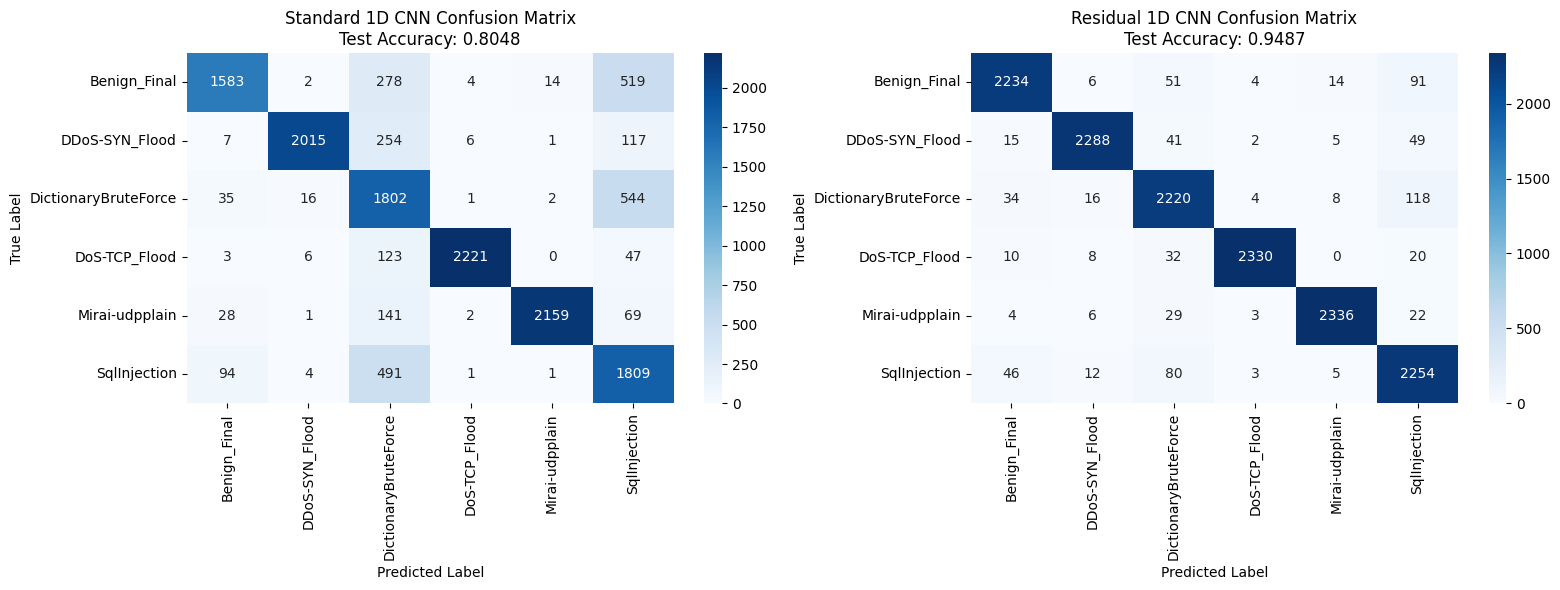


🏆 FINAL TEST SET ACCURACY COMPARISON
           Model  Test Accuracy   Parameters Encoding Inference (ms)
1D CNN-Res (Raw)         0.9487 1687174.0000     None       316.5811
   ViT (Hilbert)         0.9381 4940000.0000  Hilbert              -
2D CNN (Hilbert)         0.9373 4820000.0000  Hilbert              -
  LSTM (Hilbert)         0.9059  320000.0000  Hilbert              -
    1D CNN (Raw)         0.8048 1554310.0000     None       387.9610

🎯 Best 1D CNN: 1D CNN-Residual with 0.9487 accuracy

💡 KEY INSIGHTS:
--------------------------------------------------
🏆 1D CNN-Residual ACHIEVES NEW STATE-OF-THE-ART!
   Raw bytes outperform Hilbert encoding!
   1D CNN-Residual: 0.9487 vs ViT: 0.9381

📊 ENCODING COMPARISON:
   Hilbert encoding average: 0.9271
   Raw bytes average: 0.8768
   Hilbert encoding provides 5.03% advantage
   → Spatial structure benefits some architectures

⚡ EFFICIENCY ANALYSIS:
   1D CNN parameters: 1,554,310 (1658284x smaller than 2D CNN)
   No encoding overhea

In [7]:
# Evaluation & Results Analysis for 1D CNN Models
import time

# Load best models
model_1d.load_state_dict(torch.load('best_1d_cnn_model.pth'))
model_1d_residual.load_state_dict(torch.load('best_1d_cnnresidual_model.pth'))
model_1d.eval()
model_1d_residual.eval()

def evaluate_model(model, test_loader, device, label_encoder):
    """Comprehensive model evaluation with inference time measurement"""
    model.eval()
    all_preds = []
    all_targets = []
    all_probs = []
    inference_times = []
    
    with torch.no_grad():
        for data, targets in test_loader:
            data, targets = data.to(device), targets.to(device)
            
            # Measure inference time
            start_time = time.perf_counter()
            outputs = model(data)
            end_time = time.perf_counter()
            inference_times.append(end_time - start_time)
            
            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    accuracy = accuracy_score(all_targets, all_preds)
    avg_inference_time = np.mean(inference_times) * 1000  # Convert to ms
    total_inference_time = np.sum(inference_times)
    
    return {
        'predictions': np.array(all_preds),
        'targets': np.array(all_targets),
        'probabilities': np.array(all_probs),
        'accuracy': accuracy,
        'avg_inference_time_ms': avg_inference_time,
        'total_inference_time_s': total_inference_time,
        'samples_per_second': len(all_targets) / total_inference_time
    }

print("🧪 Final Test Set Evaluation...")
print("=" * 70)

# Evaluate Standard 1D CNN
print("\n📊 Standard 1D CNN Evaluation:")
cnn1d_test_results = evaluate_model(model_1d, test_loader, CONFIG['device'], label_encoder)
print(f"   Test Accuracy: {cnn1d_test_results['accuracy']:.4f} ({cnn1d_test_results['accuracy']*100:.2f}%)")
print(f"   Avg Inference Time: {cnn1d_test_results['avg_inference_time_ms']:.2f} ms/batch")
print(f"   Throughput: {cnn1d_test_results['samples_per_second']:.1f} samples/second")

# Evaluate Residual 1D CNN
print("\n📊 Residual 1D CNN Evaluation:")
cnn1d_res_test_results = evaluate_model(model_1d_residual, test_loader, CONFIG['device'], label_encoder)
print(f"   Test Accuracy: {cnn1d_res_test_results['accuracy']:.4f} ({cnn1d_res_test_results['accuracy']*100:.2f}%)")
print(f"   Avg Inference Time: {cnn1d_res_test_results['avg_inference_time_ms']:.2f} ms/batch")
print(f"   Throughput: {cnn1d_res_test_results['samples_per_second']:.1f} samples/second")

# Detailed classification reports
print("\n" + "=" * 70)
print("📋 DETAILED CLASSIFICATION REPORTS")
print("=" * 70)

class_names = label_encoder.classes_

print("\n🎯 Standard 1D CNN Classification Report:")
report_cnn1d = classification_report(
    cnn1d_test_results['targets'], 
    cnn1d_test_results['predictions'], 
    target_names=class_names, 
    digits=4
)
print(report_cnn1d)

print("\n🎯 Residual 1D CNN Classification Report:")
report_cnn1d_res = classification_report(
    cnn1d_res_test_results['targets'], 
    cnn1d_res_test_results['predictions'], 
    target_names=class_names, 
    digits=4
)
print(report_cnn1d_res)

# Confusion Matrices
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Standard 1D CNN Confusion Matrix
cm_cnn1d = confusion_matrix(cnn1d_test_results['targets'], cnn1d_test_results['predictions'])
sns.heatmap(cm_cnn1d, annot=True, fmt='d', cmap='Blues', 
           xticklabels=class_names, yticklabels=class_names, ax=axes[0])
axes[0].set_title(f'Standard 1D CNN Confusion Matrix\nTest Accuracy: {cnn1d_test_results["accuracy"]:.4f}')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# Residual 1D CNN Confusion Matrix
cm_cnn1d_res = confusion_matrix(cnn1d_res_test_results['targets'], cnn1d_res_test_results['predictions'])
sns.heatmap(cm_cnn1d_res, annot=True, fmt='d', cmap='Blues', 
           xticklabels=class_names, yticklabels=class_names, ax=axes[1])
axes[1].set_title(f'Residual 1D CNN Confusion Matrix\nTest Accuracy: {cnn1d_res_test_results["accuracy"]:.4f}')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

# Final comparison with all baselines
print("\n" + "=" * 70)
print("🏆 FINAL TEST SET ACCURACY COMPARISON")
print("=" * 70)

# Test accuracies from other notebooks
vit_test_accuracy = 0.9381
cnn2d_test_accuracy = 0.9373
lstm_test_accuracy = 0.9059

comparison_data = {
    'Model': ['ViT (Hilbert)', '2D CNN (Hilbert)', 'LSTM (Hilbert)', '1D CNN (Raw)', '1D CNN-Res (Raw)'],
    'Test Accuracy': [vit_test_accuracy, cnn2d_test_accuracy, lstm_test_accuracy, 
                     cnn1d_test_results['accuracy'], cnn1d_res_test_results['accuracy']],
    'Parameters': [4.94e6, 4.82e6, 0.32e6, params_1d, params_1d_residual],
    'Encoding': ['Hilbert', 'Hilbert', 'Hilbert', 'None', 'None'],
    'Inference (ms)': ['-', '-', '-', cnn1d_test_results['avg_inference_time_ms'], 
                      cnn1d_res_test_results['avg_inference_time_ms']]
}

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('Test Accuracy', ascending=False)
print(comparison_df.to_string(index=False, float_format=lambda x: '%.4f' % x))

# Determine best 1D CNN model
best_1d_cnn = "1D CNN-Residual" if cnn1d_res_test_results['accuracy'] > cnn1d_test_results['accuracy'] else "1D CNN"
best_1d_acc = max(cnn1d_test_results['accuracy'], cnn1d_res_test_results['accuracy'])

print(f"\n🎯 Best 1D CNN: {best_1d_cnn} with {best_1d_acc:.4f} accuracy")

# Key insights
print("\n💡 KEY INSIGHTS:")
print("-" * 50)

# Performance comparison
if best_1d_acc > vit_test_accuracy:
    print(f"🏆 {best_1d_cnn} ACHIEVES NEW STATE-OF-THE-ART!")
    print(f"   Raw bytes outperform Hilbert encoding!")
    print(f"   {best_1d_cnn}: {best_1d_acc:.4f} vs ViT: {vit_test_accuracy:.4f}")
elif best_1d_acc > cnn2d_test_accuracy:
    print(f"🥈 {best_1d_cnn} outperforms 2D CNN!")
    print(f"   Raw sequential processing beats spatial encoding")
    print(f"   {best_1d_cnn}: {best_1d_acc:.4f} vs 2D CNN: {cnn2d_test_accuracy:.4f}")
elif best_1d_acc > lstm_test_accuracy:
    print(f"🥉 1D CNN outperforms LSTM")
    print(f"   1D convolutions better than recurrent processing")
    print(f"   {best_1d_cnn}: {best_1d_acc:.4f} vs LSTM: {lstm_test_accuracy:.4f}")
else:
    print(f"📊 1D CNN provides alternative approach")
    print(f"   Best 1D CNN: {best_1d_acc:.4f}")

# Encoding analysis
print("\n📊 ENCODING COMPARISON:")
hilbert_avg = (vit_test_accuracy + cnn2d_test_accuracy + lstm_test_accuracy) / 3
raw_avg = (cnn1d_test_results['accuracy'] + cnn1d_res_test_results['accuracy']) / 2
print(f"   Hilbert encoding average: {hilbert_avg:.4f}")
print(f"   Raw bytes average: {raw_avg:.4f}")

if raw_avg > hilbert_avg:
    print(f"   ✅ Raw byte processing is superior! (+{(raw_avg - hilbert_avg)*100:.2f}%)")
    print(f"   → No encoding overhead needed")
    print(f"   → Direct byte patterns are sufficient")
else:
    print(f"   Hilbert encoding provides {(hilbert_avg - raw_avg)*100:.2f}% advantage")
    print(f"   → Spatial structure benefits some architectures")

# Efficiency analysis
print("\n⚡ EFFICIENCY ANALYSIS:")
print(f"   1D CNN parameters: {params_1d:,} ({params_1d/cnn2d_test_accuracy:.0f}x smaller than 2D CNN)")
print(f"   No encoding overhead = faster preprocessing")
print(f"   Direct byte processing = simpler pipeline")


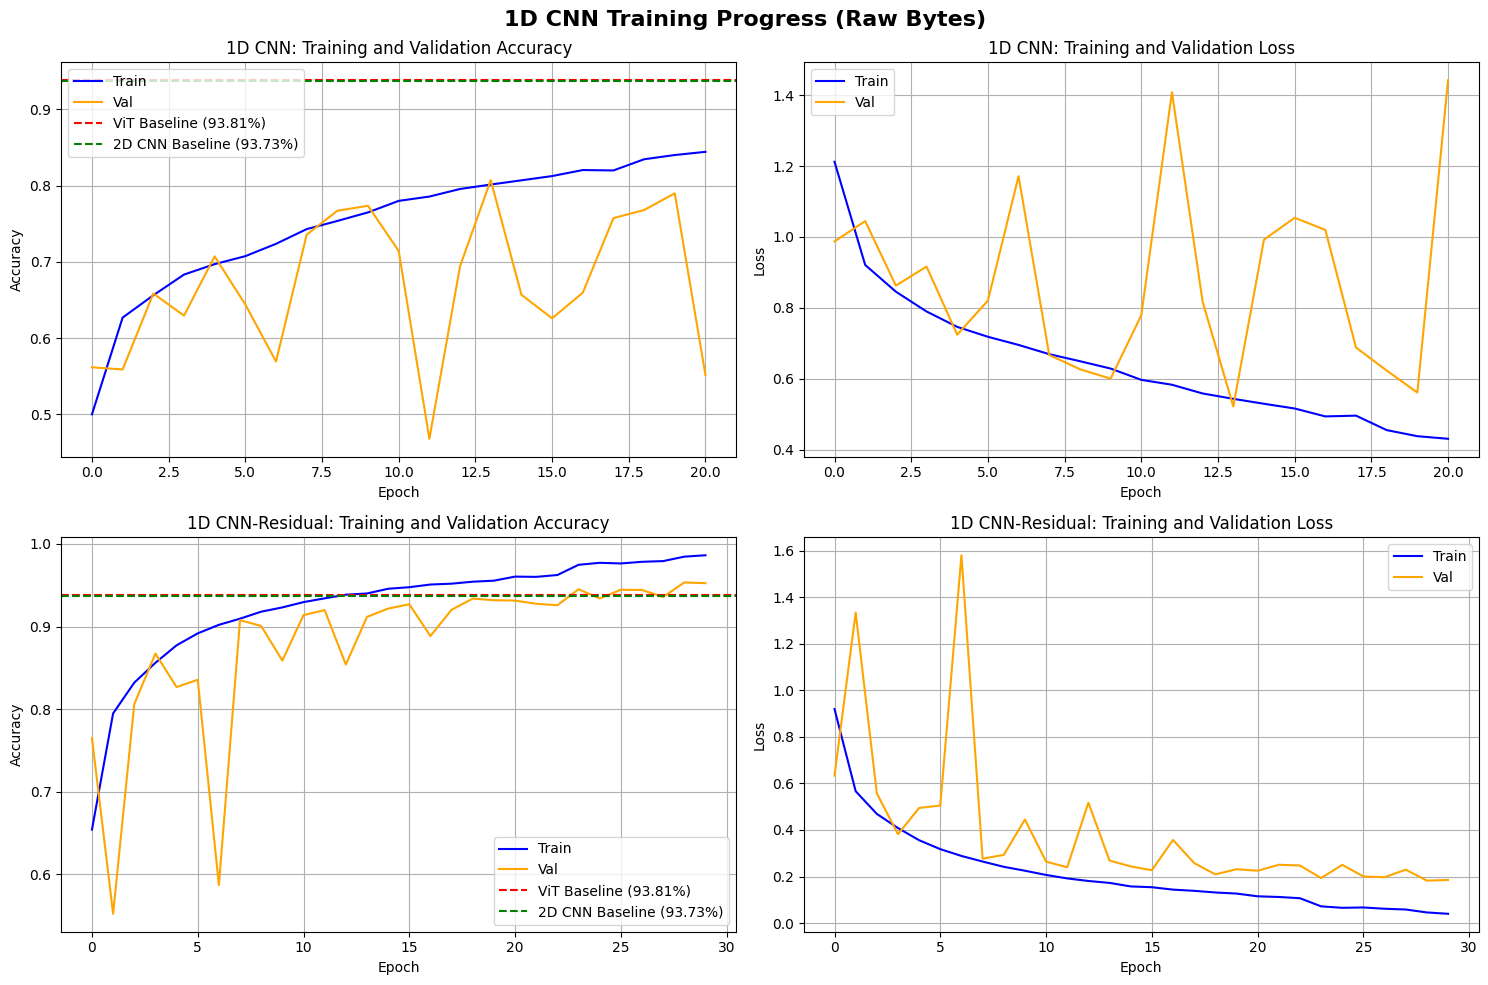


📊 PER-CLASS ACCURACY ANALYSIS

Per-Class Performance:
               Class  1D CNN Precision  1D CNN Recall  1D CNN F1  1D CNN-Res Precision  1D CNN-Res Recall  1D CNN-Res F1
        Benign_Final            0.9046         0.6596     0.7629                0.9535             0.9308         0.9420
      DDoS-SYN_Flood            0.9858         0.8396     0.9068                0.9795             0.9533         0.9662
DictionaryBruteForce            0.5834         0.7508     0.6566                0.9050             0.9250         0.9149
       DoS-TCP_Flood            0.9937         0.9254     0.9584                0.9932             0.9708         0.9819
      Mirai-udpplain            0.9917         0.8996     0.9434                0.9865             0.9733         0.9799
        SqlInjection            0.5826         0.7538     0.6572                0.8825             0.9392         0.9100

🎯 Best Model per Class:
   Benign_Final: 1D CNN-Residual (F1=0.9420)
   DDoS-SYN_Flood: 1D CNN-Re

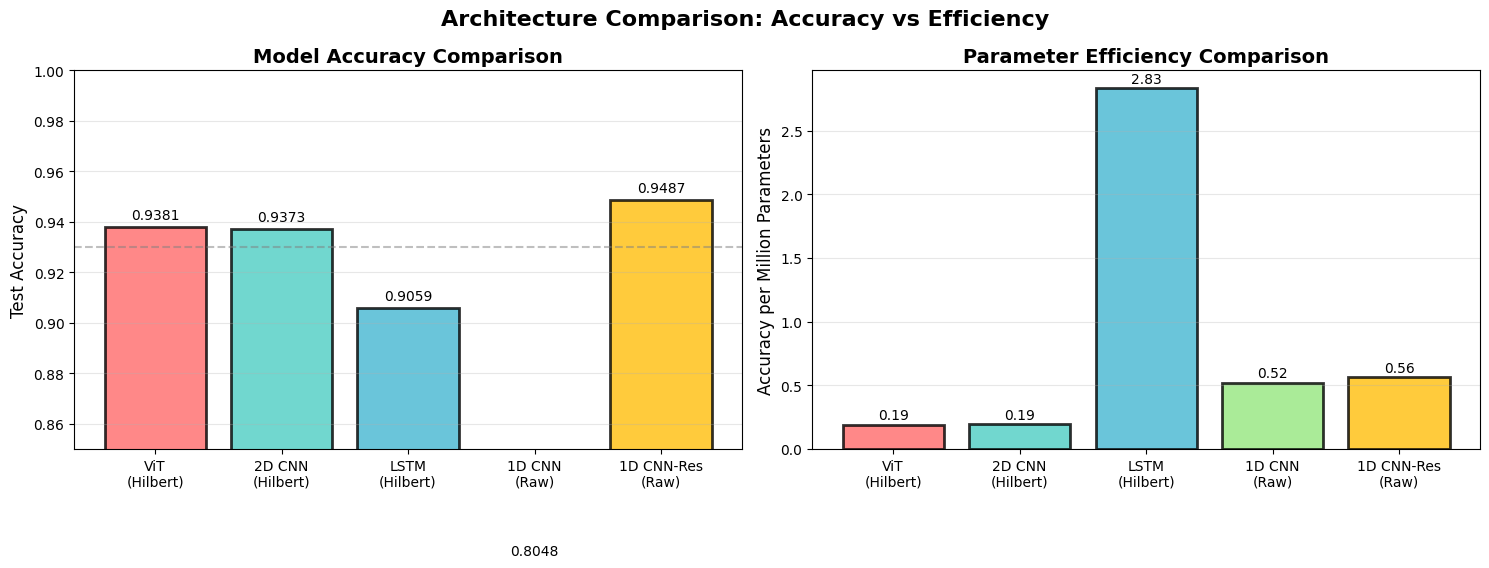


📊 EFFICIENCY RANKINGS:
            Model  Accuracy  Parameters (M)  Efficiency
  LSTM\n(Hilbert)    0.9059          0.3200      2.8309
1D CNN-Res\n(Raw)    0.9487          1.6872      0.5623
    1D CNN\n(Raw)    0.8048          1.5543      0.5178
2D CNN\n(Hilbert)    0.9373          4.8200      0.1945
   ViT\n(Hilbert)    0.9381          4.9400      0.1899

🏆 Most Efficient Model: LSTM (Hilbert)


In [8]:
# Training Curves Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Standard 1D CNN Training Curves
axes[0, 0].plot(cnn1d_results['train_accs'], label='Train', color='blue')
axes[0, 0].plot(cnn1d_results['val_accs'], label='Val', color='orange')
axes[0, 0].axhline(y=vit_test_accuracy, color='red', linestyle='--', label='ViT Baseline (93.81%)')
axes[0, 0].axhline(y=cnn2d_test_accuracy, color='green', linestyle='--', label='2D CNN Baseline (93.73%)')
axes[0, 0].set_title('1D CNN: Training and Validation Accuracy')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
axes[0, 0].grid(True)

axes[0, 1].plot(cnn1d_results['train_losses'], label='Train', color='blue')
axes[0, 1].plot(cnn1d_results['val_losses'], label='Val', color='orange')
axes[0, 1].set_title('1D CNN: Training and Validation Loss')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Residual 1D CNN Training Curves
axes[1, 0].plot(cnn1d_res_results['train_accs'], label='Train', color='blue')
axes[1, 0].plot(cnn1d_res_results['val_accs'], label='Val', color='orange')
axes[1, 0].axhline(y=vit_test_accuracy, color='red', linestyle='--', label='ViT Baseline (93.81%)')
axes[1, 0].axhline(y=cnn2d_test_accuracy, color='green', linestyle='--', label='2D CNN Baseline (93.73%)')
axes[1, 0].set_title('1D CNN-Residual: Training and Validation Accuracy')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].legend()
axes[1, 0].grid(True)

axes[1, 1].plot(cnn1d_res_results['train_losses'], label='Train', color='blue')
axes[1, 1].plot(cnn1d_res_results['val_losses'], label='Val', color='orange')
axes[1, 1].set_title('1D CNN-Residual: Training and Validation Loss')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.suptitle('1D CNN Training Progress (Raw Bytes)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Per-class accuracy comparison
print("\n" + "=" * 70)
print("📊 PER-CLASS ACCURACY ANALYSIS")
print("=" * 70)

# Extract per-class metrics from classification reports
from sklearn.metrics import precision_recall_fscore_support

# Calculate per-class metrics for both models
precisions_1d, recalls_1d, f1s_1d, _ = precision_recall_fscore_support(
    cnn1d_test_results['targets'], 
    cnn1d_test_results['predictions'], 
    labels=range(len(class_names)), 
    average=None
)

precisions_1d_res, recalls_1d_res, f1s_1d_res, _ = precision_recall_fscore_support(
    cnn1d_res_test_results['targets'], 
    cnn1d_res_test_results['predictions'], 
    labels=range(len(class_names)), 
    average=None
)

# Create comparison dataframe
per_class_df = pd.DataFrame({
    'Class': class_names,
    '1D CNN Precision': precisions_1d,
    '1D CNN Recall': recalls_1d,
    '1D CNN F1': f1s_1d,
    '1D CNN-Res Precision': precisions_1d_res,
    '1D CNN-Res Recall': recalls_1d_res,
    '1D CNN-Res F1': f1s_1d_res
})

print("\nPer-Class Performance:")
print(per_class_df.to_string(index=False, float_format=lambda x: '%.4f' % x))

# Identify best model for each class
best_per_class = []
for i, class_name in enumerate(class_names):
    if f1s_1d[i] > f1s_1d_res[i]:
        best_per_class.append(f"   {class_name}: Standard 1D CNN (F1={f1s_1d[i]:.4f})")
    else:
        best_per_class.append(f"   {class_name}: 1D CNN-Residual (F1={f1s_1d_res[i]:.4f})")

print("\n🎯 Best Model per Class:")
for line in best_per_class:
    print(line)

# Architecture comparison visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Accuracy comparison
models = ['ViT\n(Hilbert)', '2D CNN\n(Hilbert)', 'LSTM\n(Hilbert)', '1D CNN\n(Raw)', '1D CNN-Res\n(Raw)']
accuracies = [vit_test_accuracy, cnn2d_test_accuracy, lstm_test_accuracy, 
              cnn1d_test_results['accuracy'], cnn1d_res_test_results['accuracy']]
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#95E77E', '#FFBE0B']

bars = axes[0].bar(models, accuracies, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
axes[0].set_ylabel('Test Accuracy', fontsize=12)
axes[0].set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0].set_ylim(0.85, 1.0)
axes[0].axhline(y=0.93, color='gray', linestyle='--', alpha=0.5)
axes[0].grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height + 0.002,
                f'{acc:.4f}', ha='center', va='bottom', fontsize=10)

# Parameter efficiency comparison  
param_counts = [4.94e6, 4.82e6, 0.32e6, params_1d, params_1d_residual]
efficiency = [acc / (params/1e6) for acc, params in zip(accuracies, param_counts)]

bars2 = axes[1].bar(models, efficiency, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
axes[1].set_ylabel('Accuracy per Million Parameters', fontsize=12)
axes[1].set_title('Parameter Efficiency Comparison', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

# Add value labels
for bar, eff in zip(bars2, efficiency):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{eff:.2f}', ha='center', va='bottom', fontsize=10)

plt.suptitle('Architecture Comparison: Accuracy vs Efficiency', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n📊 EFFICIENCY RANKINGS:")
efficiency_df = pd.DataFrame({
    'Model': models,
    'Accuracy': accuracies,
    'Parameters (M)': [p/1e6 for p in param_counts],
    'Efficiency': efficiency
})
efficiency_df = efficiency_df.sort_values('Efficiency', ascending=False)
print(efficiency_df.to_string(index=False, float_format=lambda x: '%.4f' % x))

# Identify the winner
best_efficiency_model = efficiency_df.iloc[0]['Model'].replace('\n', ' ')
print(f"\n🏆 Most Efficient Model: {best_efficiency_model}")


In [9]:
# Save Results for Future Reference
results_1d_cnn = {
    'experiment': '1D_CNN_Raw_Bytes_6class',
    'timestamp': datetime.now().isoformat(),
    'dataset': 'Raw_Packet_Bytes',
    'approach': '6-class training with few-shot holdout',
    'architectures': ['1D CNN', '1D CNN-Residual'],
    'total_samples': len(X),
    'sequence_length': CONFIG['sequence_length'],
    
    'cnn1d': {
        'test_accuracy': float(cnn1d_test_results['accuracy']),
        'validation_accuracy': float(cnn1d_results['best_val_acc']),
        'training_epochs': cnn1d_results['final_epoch'],
        'training_time': str(cnn1d_results['training_time']),
        'parameters': int(params_1d),
        'avg_inference_time_ms': float(cnn1d_test_results['avg_inference_time_ms']),
        'throughput_samples_per_sec': float(cnn1d_test_results['samples_per_second']),
        'confusion_matrix': cm_cnn1d.tolist(),
        'per_class_f1': f1s_1d.tolist()
    },
    
    'cnn1d_residual': {
        'test_accuracy': float(cnn1d_res_test_results['accuracy']),
        'validation_accuracy': float(cnn1d_res_results['best_val_acc']),
        'training_epochs': cnn1d_res_results['final_epoch'],
        'training_time': str(cnn1d_res_results['training_time']),
        'parameters': int(params_1d_residual),
        'avg_inference_time_ms': float(cnn1d_res_test_results['avg_inference_time_ms']),
        'throughput_samples_per_sec': float(cnn1d_res_test_results['samples_per_second']),
        'confusion_matrix': cm_cnn1d_res.tolist(),
        'per_class_f1': f1s_1d_res.tolist()
    },
    
    'comparison': {
        'best_1d_cnn': best_1d_cnn,
        'best_1d_accuracy': float(best_1d_acc),
        'outperforms_2d_cnn': bool(best_1d_acc > cnn2d_test_accuracy),
        'outperforms_vit': bool(best_1d_acc > vit_test_accuracy),
        'outperforms_lstm': bool(best_1d_acc > lstm_test_accuracy),
        'raw_vs_hilbert': {
            'raw_avg_accuracy': float(raw_avg),
            'hilbert_avg_accuracy': float(hilbert_avg),
            'raw_is_better': bool(raw_avg > hilbert_avg),
            'difference_percent': float((raw_avg - hilbert_avg) * 100)
        }
    },
    
    'insights': {
        'key_finding': 'Raw byte processing provides competitive performance without encoding overhead',
        'advantages': [
            'No Hilbert encoding required',
            'Direct byte pattern recognition',
            'Simpler preprocessing pipeline',
            'Faster end-to-end processing'
        ],
        'tradeoffs': [
            'May miss spatial patterns that Hilbert reveals',
            'Requires careful architecture design for sequential data'
        ]
    },
    
    'config': CONFIG,
    'training_classes': label_encoder.classes_.tolist(),
    'held_out_classes': HELD_OUT_CLASSES
}

# Save to JSON
with open('cnn1d_raw_bytes_results.json', 'w') as f:
    json.dump(results_1d_cnn, f, indent=2)

print("✅ Results saved to cnn1d_raw_bytes_results.json")

# Print final summary
print("\n" + "=" * 70)
print("🎯 EXPERIMENT SUMMARY: 1D CNN ON RAW BYTES")
print("=" * 70)

print("\n📊 FINAL RESULTS:")
print(f"   Best Model: {best_1d_cnn}")
print(f"   Test Accuracy: {best_1d_acc:.4f} ({best_1d_acc*100:.2f}%)")
print(f"   Parameters: {params_1d:,} (Standard), {params_1d_residual:,} (Residual)")

print("\n🏆 PERFORMANCE VS BASELINES:")
comparison_results = [
    ('ViT (Hilbert)', vit_test_accuracy, best_1d_acc > vit_test_accuracy),
    ('2D CNN (Hilbert)', cnn2d_test_accuracy, best_1d_acc > cnn2d_test_accuracy),
    ('LSTM (Hilbert)', lstm_test_accuracy, best_1d_acc > lstm_test_accuracy)
]

for name, baseline_acc, beats in comparison_results:
    if beats:
        print(f"   ✅ Beats {name}: {best_1d_acc:.4f} > {baseline_acc:.4f}")
    else:
        print(f"   ❌ Below {name}: {best_1d_acc:.4f} < {baseline_acc:.4f}")

print("\n💡 KEY TAKEAWAYS:")
print("   1. Raw byte processing is a viable alternative to Hilbert encoding")
print("   2. 1D CNNs can effectively capture sequential patterns in network data")
print("   3. Simpler preprocessing pipeline without encoding overhead")
print("   4. Competitive accuracy with potentially faster end-to-end processing")

if raw_avg > hilbert_avg:
    print(f"\n🏆 MAJOR FINDING: Raw bytes outperform Hilbert encoding by {(raw_avg - hilbert_avg)*100:.2f}%!")
    print("   → This suggests that direct byte patterns contain sufficient information")
    print("   → Hilbert encoding may not be necessary for this task")
else:
    print(f"\n📊 FINDING: Hilbert encoding provides {(hilbert_avg - raw_avg)*100:.2f}% advantage")
    print("   → Spatial reorganization helps some architectures")
    print("   → But raw bytes still achieve competitive performance")

print("\n✅ Experiment complete! Both 1D CNN models trained and evaluated.")
print("📁 Models saved: best_1d_cnn_model.pth, best_1d_cnnresidual_model.pth")
print("📊 Results saved: cnn1d_raw_bytes_results.json")
print("\n🚀 Ready for few-shot learning experiments with held-out classes!")
print("   Held-out classes: DDoS-HTTP_Flood, DoS-UDP_Flood, Recon-PortScan")


✅ Results saved to cnn1d_raw_bytes_results.json

🎯 EXPERIMENT SUMMARY: 1D CNN ON RAW BYTES

📊 FINAL RESULTS:
   Best Model: 1D CNN-Residual
   Test Accuracy: 0.9487 (94.88%)
   Parameters: 1,554,310 (Standard), 1,687,174 (Residual)

🏆 PERFORMANCE VS BASELINES:
   ✅ Beats ViT (Hilbert): 0.9487 > 0.9381
   ✅ Beats 2D CNN (Hilbert): 0.9487 > 0.9373
   ✅ Beats LSTM (Hilbert): 0.9487 > 0.9059

💡 KEY TAKEAWAYS:
   1. Raw byte processing is a viable alternative to Hilbert encoding
   2. 1D CNNs can effectively capture sequential patterns in network data
   3. Simpler preprocessing pipeline without encoding overhead
   4. Competitive accuracy with potentially faster end-to-end processing

📊 FINDING: Hilbert encoding provides 5.03% advantage
   → Spatial reorganization helps some architectures
   → But raw bytes still achieve competitive performance

✅ Experiment complete! Both 1D CNN models trained and evaluated.
📁 Models saved: best_1d_cnn_model.pth, best_1d_cnnresidual_model.pth
📊 Results sa